In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import mne
from scipy.stats import linregress

import mni_utils as uti
from mni_plots import plot_corr_tau_sc, plot_sc_fit, plot_stages_diff

### Paths and names

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
res_dir = "Results_SC"
res_tau_dir = "Results"
res_path = data_path.joinpath(res_dir)
res_tau_path = data_path.joinpath(res_tau_dir)

## 1) Load SC parameters, timescales and parcellation

Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

SC results and parameters:

In [43]:
# Dataframe with data on all channles pairs
df_sc_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the total binned data
df_sc_bins_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_bins.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Fitted on binned distance:
df_sc_params_mni_stages_bins = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mni_regs_bins.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters on each MMP region
df_sc_params_mmp_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mmp_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Fitted on binned distance:
df_sc_params_mmp_stages_bins = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mmp_regs_bins.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

Timescales:

In [6]:
# Dataframe with timescales for all electrodes
df_tau = pd.read_csv(
    res_tau_path.joinpath("all_tau.csv"), index_col=0
)

# Dataframe with information on parcellated timescales values
df_tau_parc = {
    stage: pd.read_csv(res_tau_path.joinpath(f"tau_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

## 2) Plot SC parameters globally and for each region

Plot of fits:

{'W': array([10.31544796,  0.28810056,  0.04850013]), 'N3': array([8.30565901, 0.25270324, 0.06400945]), 'R': array([7.88810727, 0.23313814, 0.04821154])}


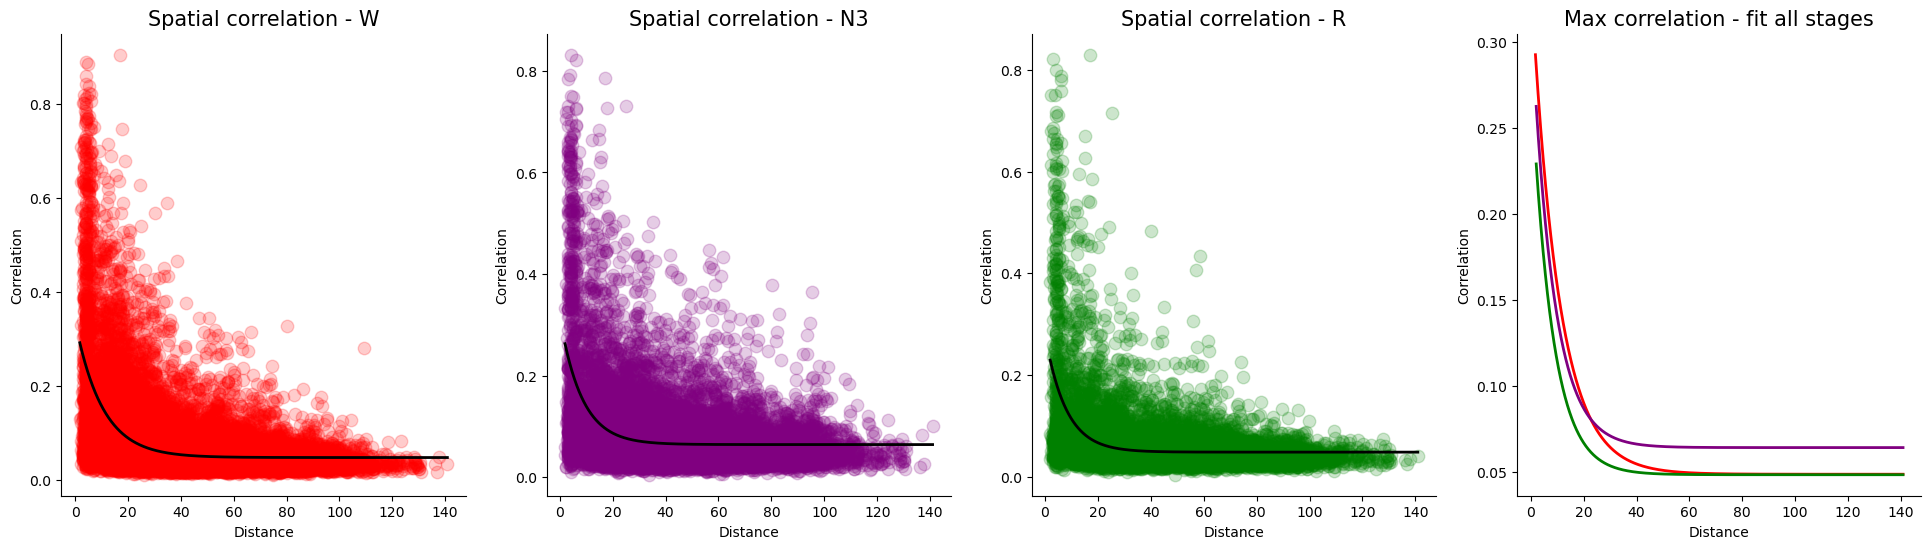

In [29]:
colors_stage = {
    "W": "r",
    "N3": "purple",
    "R": "g"
}
params_stages = {stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages.items()}
print(params_stages)
fig, axs = plot_sc_fit(df_sc_stages, params_stages, colors_stage)
plt.show()

Plot of regions, "b" parameter:

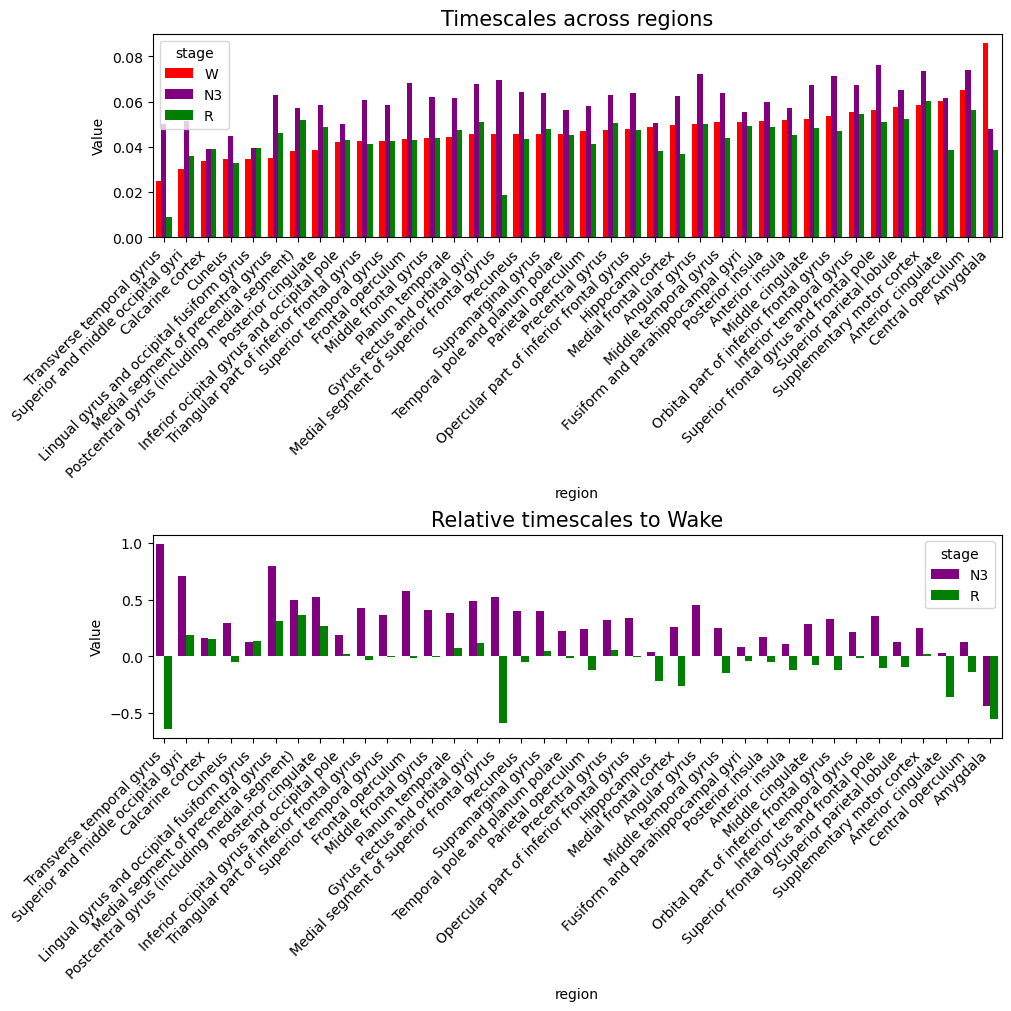

In [49]:
for stage, df in df_sc_params_mni_stages.items():
    if "stage" not in df.columns:
        df.insert(0, "stage", stage) 

df_params = pd.concat(df_sc_params_mni_stages.values())
df_params.reset_index(names="region", inplace=True)

fig, axs = plot_stages_diff(df_params, "b")
plt.show()

## 3) Plot relationship between timescales and SC parameters

With the MNI atlas division:

Stage: W, Param: k
Linregress results: r = -0.0545051566332884, p = 0.7451733435444186
Speraman results: r = -0.15898894846263267, p = 0.34037872975756966
Stage: W, Param: a
Linregress results: r = -0.26495348853346085, p = 0.10792231635747429
Speraman results: r = -0.0747346536820221, p = 0.655647591896354
Stage: W, Param: b
Linregress results: r = 0.4303692901365354, p = 0.006995645183040359
Speraman results: r = 0.3314366998577525, p = 0.04208076882023831


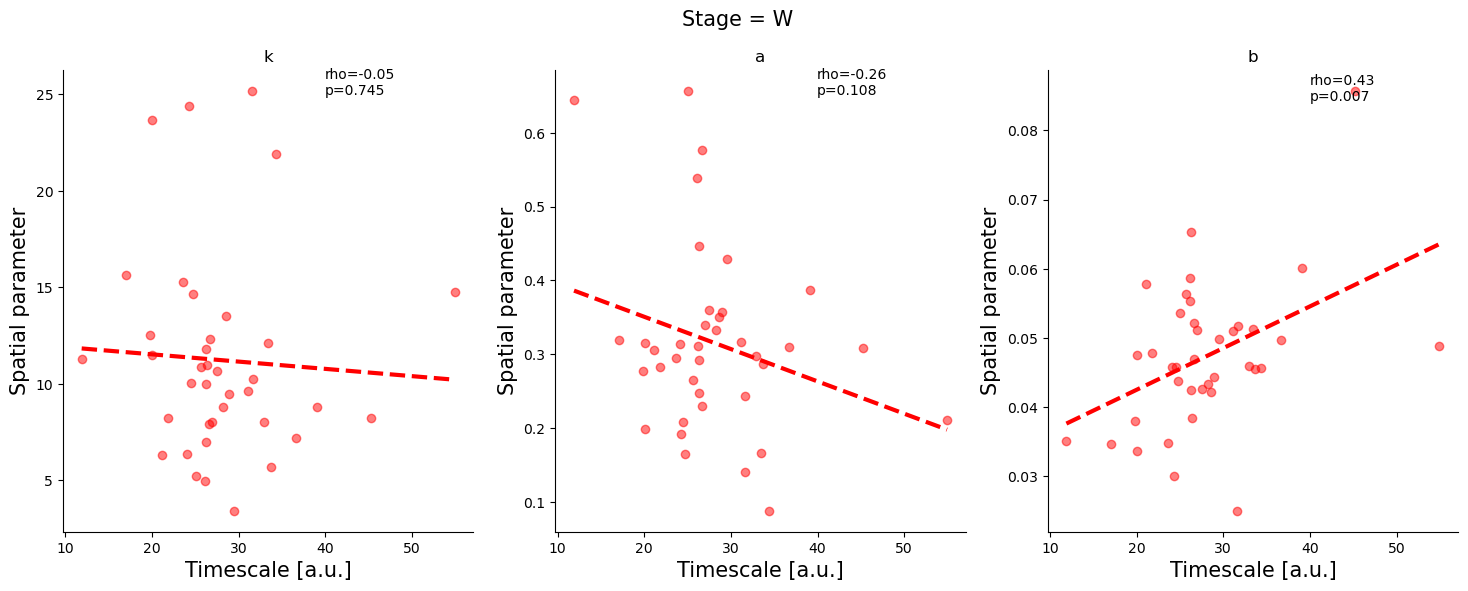

Stage: N3, Param: k
Linregress results: r = -0.34780576371300764, p = 0.03237863398972034
Speraman results: r = -0.2894189736294999, p = 0.07799533519095163
Stage: N3, Param: a
Linregress results: r = 0.14194532371896532, p = 0.3952715093374338
Speraman results: r = 0.10187110187110189, p = 0.5427997625317484
Stage: N3, Param: b
Linregress results: r = 0.5499033185003882, p = 0.00034843598890341897
Speraman results: r = 0.4421709158551264, p = 0.005443509798399983


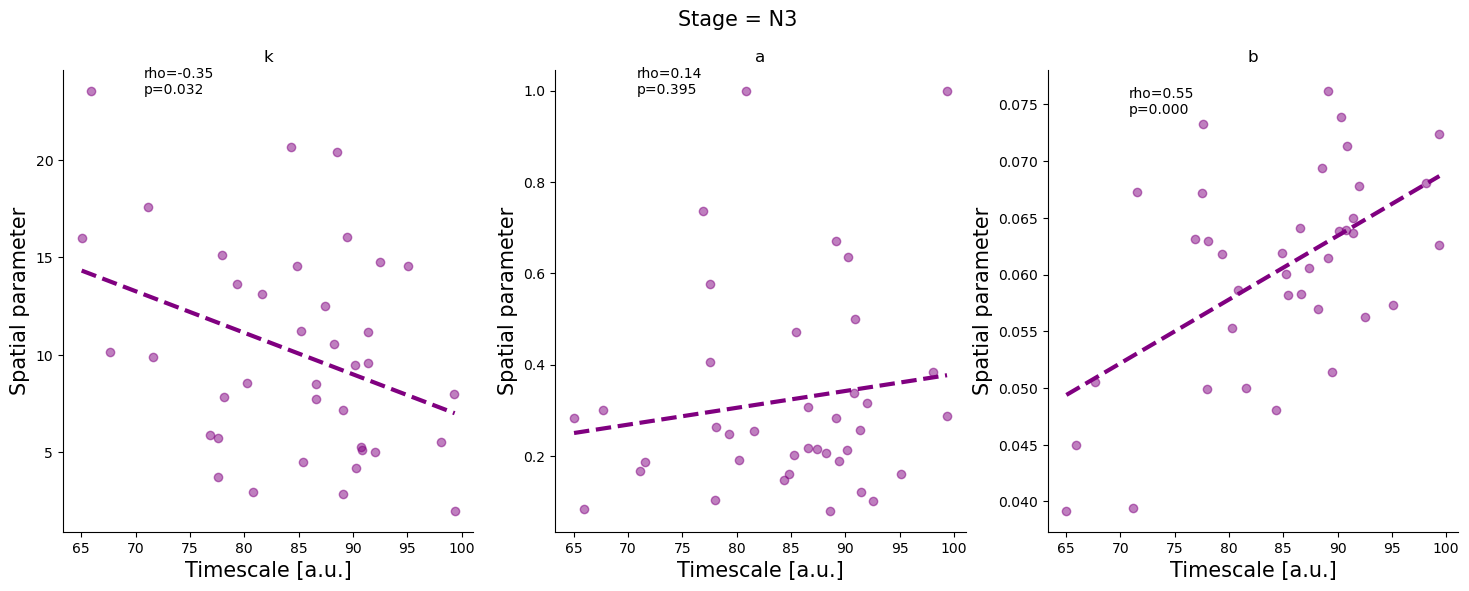

Stage: R, Param: k
Linregress results: r = 0.24493192159491356, p = 0.1383120662162826
Speraman results: r = 0.23952292373345005, p = 0.14751214490229414
Stage: R, Param: a
Linregress results: r = -0.2166217178238646, p = 0.19144611687328714
Speraman results: r = -0.11281321807637597, p = 0.5000860849880437
Stage: R, Param: b
Linregress results: r = -0.36691522753414746, p = 0.02345510339226503
Speraman results: r = -0.39271255060728744, p = 0.014734013118131327


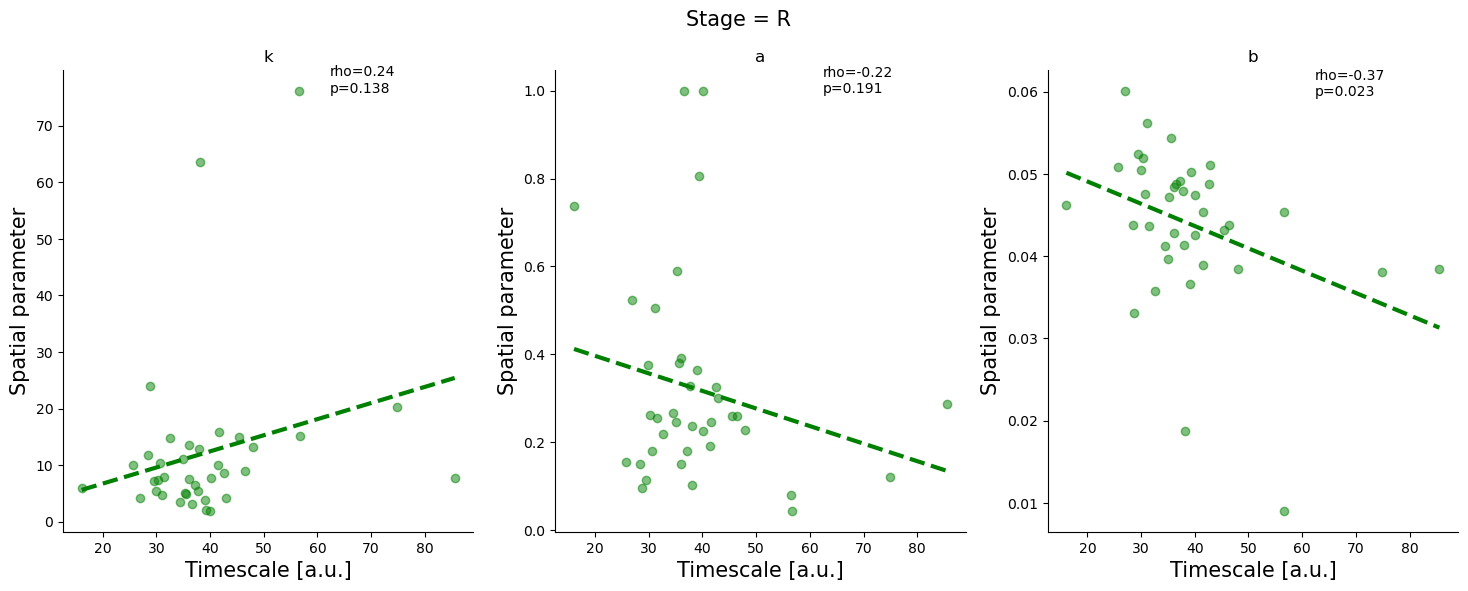

In [7]:
colors_stage = {
    "W": "r",
    "N3": "purple",
    "R": "g"
}

for stage in ["W", "N3", "R"]:

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18,6])
    fig.suptitle(f"Stage = {stage}", fontsize=15)

    # Plot one subplot per parameter
    for i, param in enumerate(["k", "a", "b"]):

        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        print(f"Stage: {stage}, Param: {param}")
        axs[i] = plot_corr_tau_sc(axs[i], df_tau_stage_mni, df_spa, title=param, color=colors_stage[stage])
        
    plt.show()

With the MMP atlas division:

Stage: W, Param: k
Linregress results: r = -0.05667151996820852, p = 0.4794034614217676
Speraman results: r = -0.09335000623982681, p = 0.2433623972004754
Stage: W, Param: a
Linregress results: r = 0.0024380610012064378, p = 0.9757459262651007
Speraman results: r = -0.09207742007214385, p = 0.24987571122179048
Stage: W, Param: b
Linregress results: r = 0.13492341826356247, p = 0.09098352516653739
Speraman results: r = 0.032282208047657364, p = 0.6871954162968206


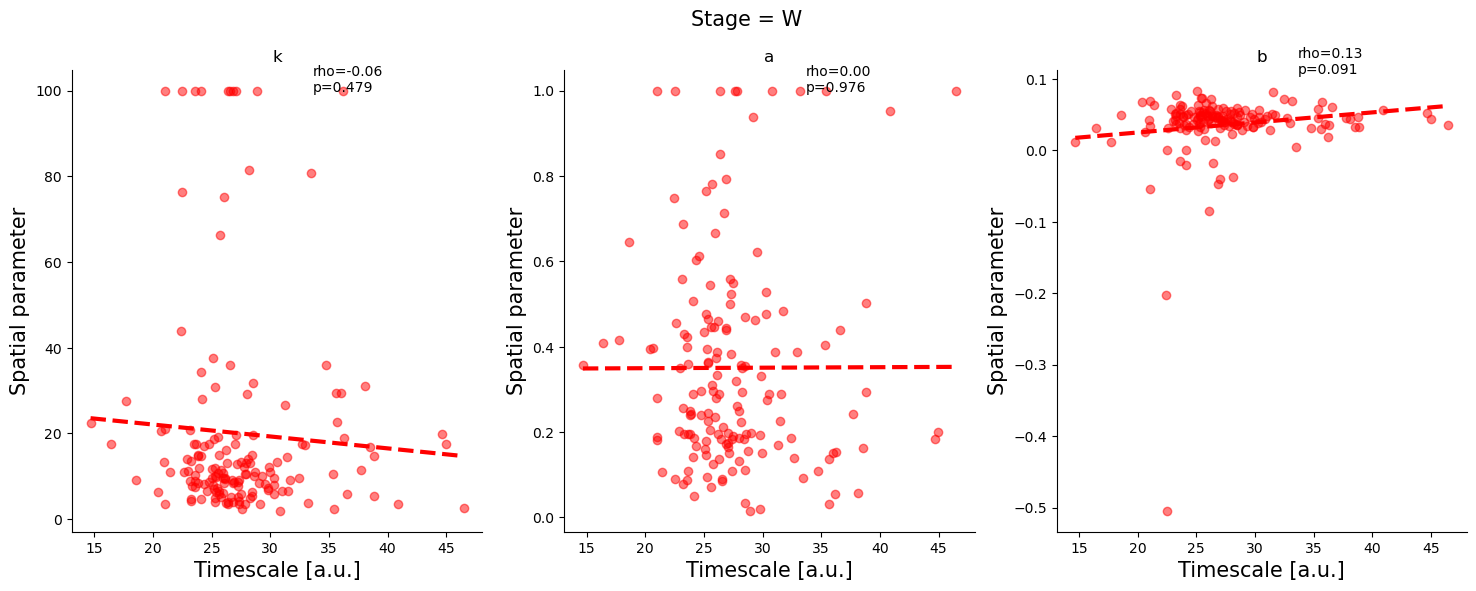

Stage: N3, Param: k
Linregress results: r = -0.02879730796785788, p = 0.7229438549824514
Speraman results: r = 0.05590996838147248, p = 0.49100540314839625
Stage: N3, Param: a
Linregress results: r = -0.12510650706161255, p = 0.12211368705099498
Speraman results: r = -0.1542369623234335, p = 0.05614857813825499
Stage: N3, Param: b
Linregress results: r = 0.2074813410713791, p = 0.009824153949371497
Speraman results: r = 0.13736661820153284, p = 0.08934756728160027


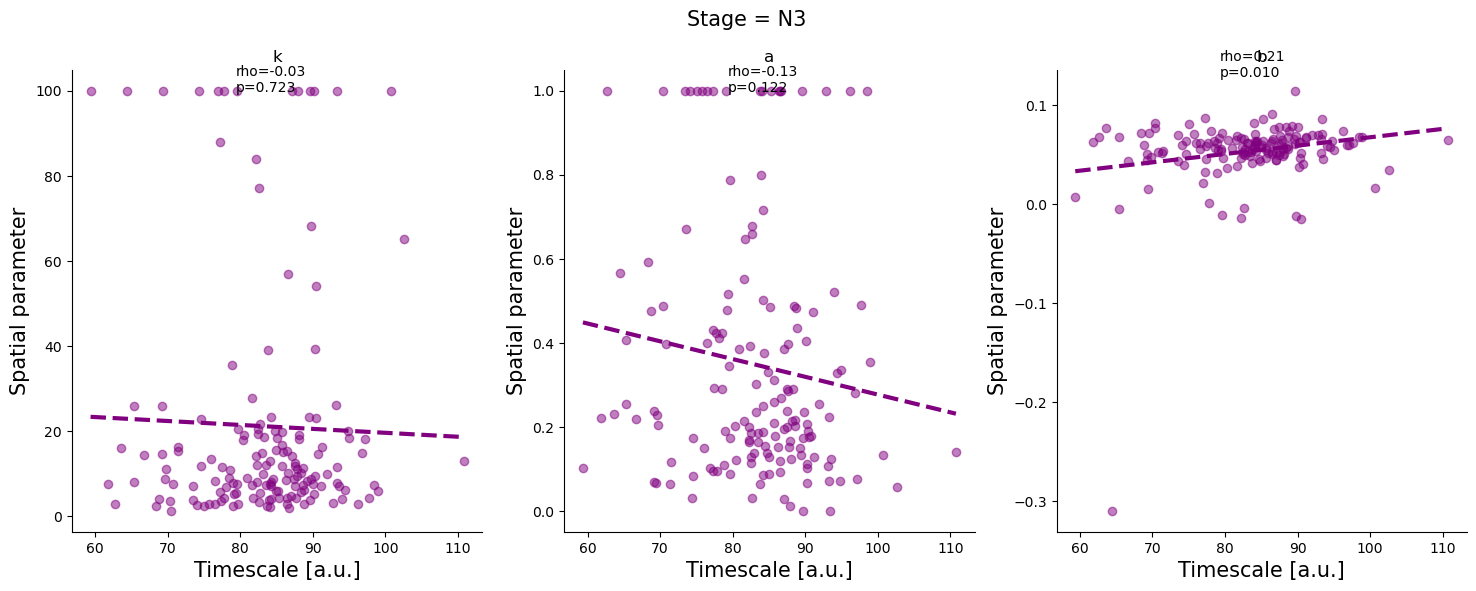

Stage: R, Param: k
Linregress results: r = 0.10730425037139087, p = 0.20864215539467965
Speraman results: r = 0.14226219070317409, p = 0.09479897799826306
Stage: R, Param: a
Linregress results: r = -0.12632185724355902, p = 0.13839177229723967
Speraman results: r = -0.11452578141988423, p = 0.1794444077564032
Stage: R, Param: b
Linregress results: r = -0.21307053743950896, p = 0.011789992169898681
Speraman results: r = -0.22743643594441215, p = 0.007089638659288291


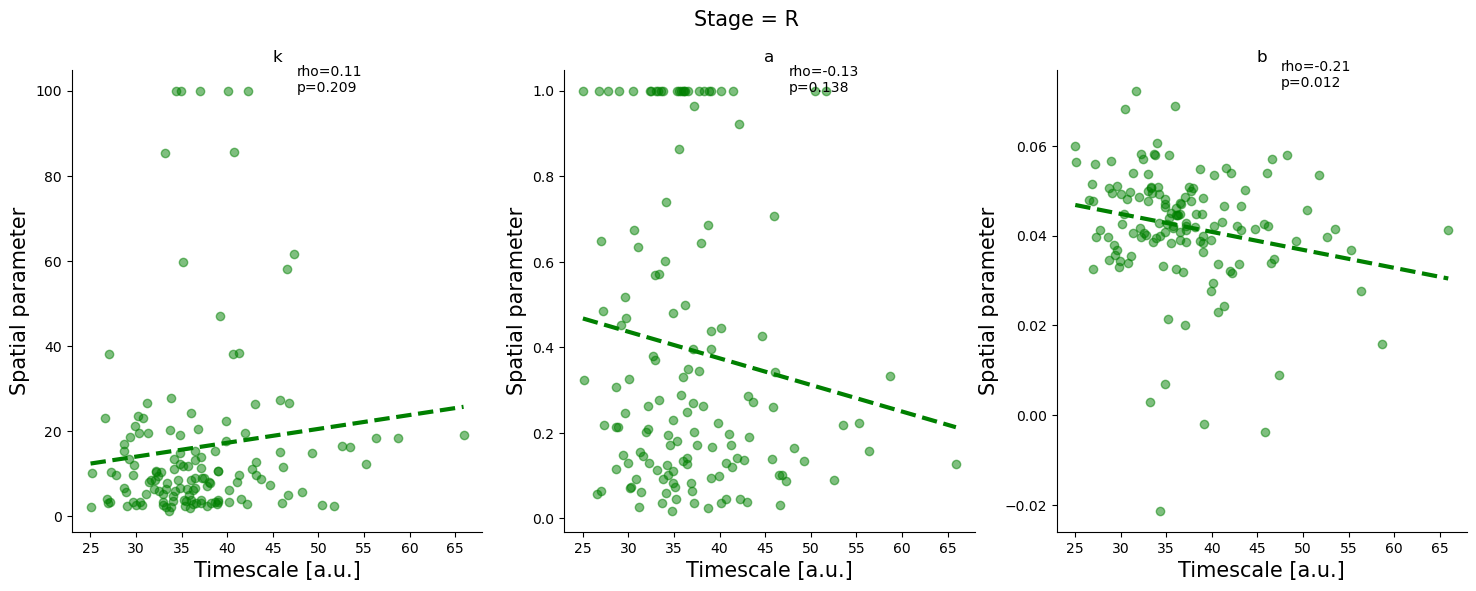

In [8]:
colors_stage = {
    "W": "r",
    "N3": "purple",
    "R": "g"
}

for stage in ["W", "N3", "R"]:

    # Get average tau per MNI region
    df_tau_stage_mmp = df_tau_parc[stage].copy()

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18,6])
    fig.suptitle(f"Stage = {stage}", fontsize=15)

    # Plot one subplot per parameter
    for i, param in enumerate(["k", "a", "b"]):

        df_spa = df_sc_params_mmp_stages[stage][param].astype(float)
        df_spa.dropna(inplace=True)
        # Check same regions are present
        df_tau_stage_mmp = df_tau_stage_mmp[df_tau_stage_mmp.index.isin(df_spa.index)]
        print(f"Stage: {stage}, Param: {param}")
        axs[i] = plot_corr_tau_sc(axs[i], df_tau_stage_mmp, df_spa, title=param, color=colors_stage[stage])
        
    plt.show()

## 4) Plot relationship between timescales and SC parameters (binned distance)

With the MNI atlas division:

Stage: W, Param: k
Linregress results: r = 0.1799454739999055, p = 0.2796712576029928
Speraman results: r = 0.014115329904803589, p = 0.932968852476463
Stage: W, Param: a
Linregress results: r = -0.19954179054204013, p = 0.2297153054839887
Speraman results: r = -0.23886639676113355, p = 0.14865858417664363
Stage: W, Param: b
Linregress results: r = 0.40002764722465045, p = 0.012830299808838368
Speraman results: r = 0.1425757741547215, p = 0.3931542395387482


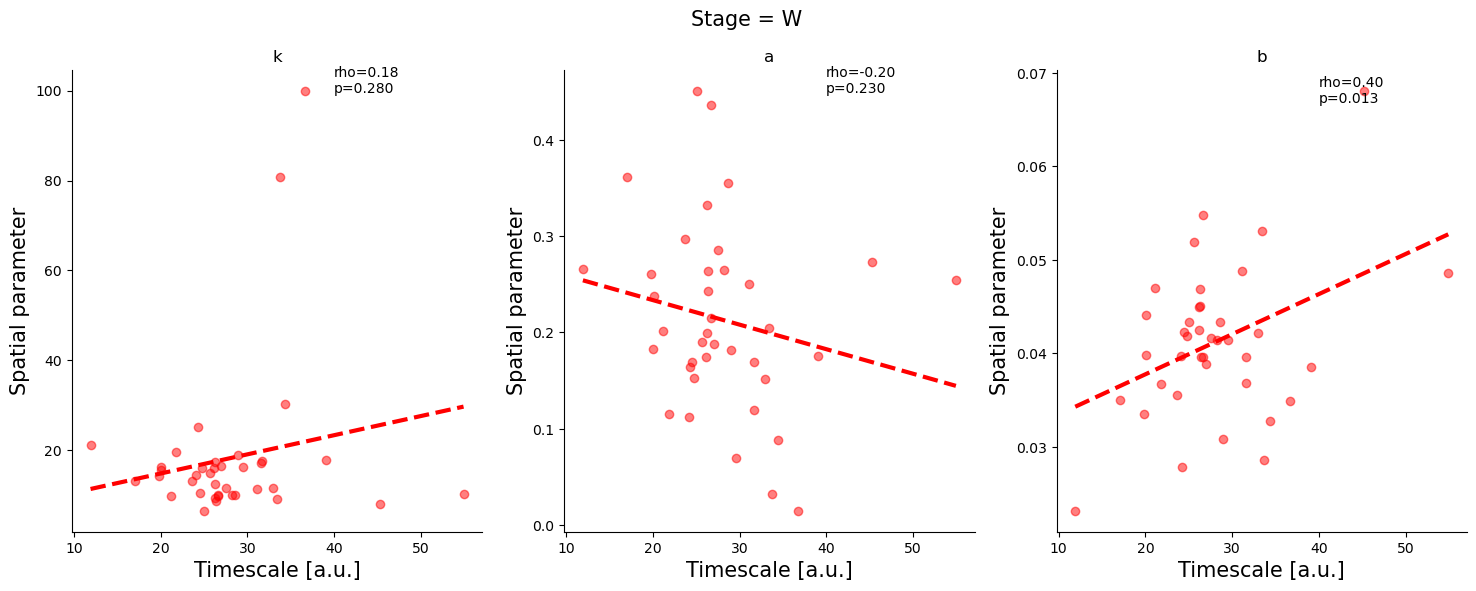

Stage: N3, Param: k
Linregress results: r = -0.0518268955365029, p = 0.7573079614082541
Speraman results: r = -0.11238168206348972, p = 0.5017376329696153
Stage: N3, Param: a
Linregress results: r = 0.041221084936025144, p = 0.8058991355771695
Speraman results: r = 0.03928219717693402, p = 0.8148662896182437
Stage: N3, Param: b
Linregress results: r = 0.26681295088956614, p = 0.10538037258076742
Speraman results: r = 0.3091147827989933, p = 0.05897232586780473


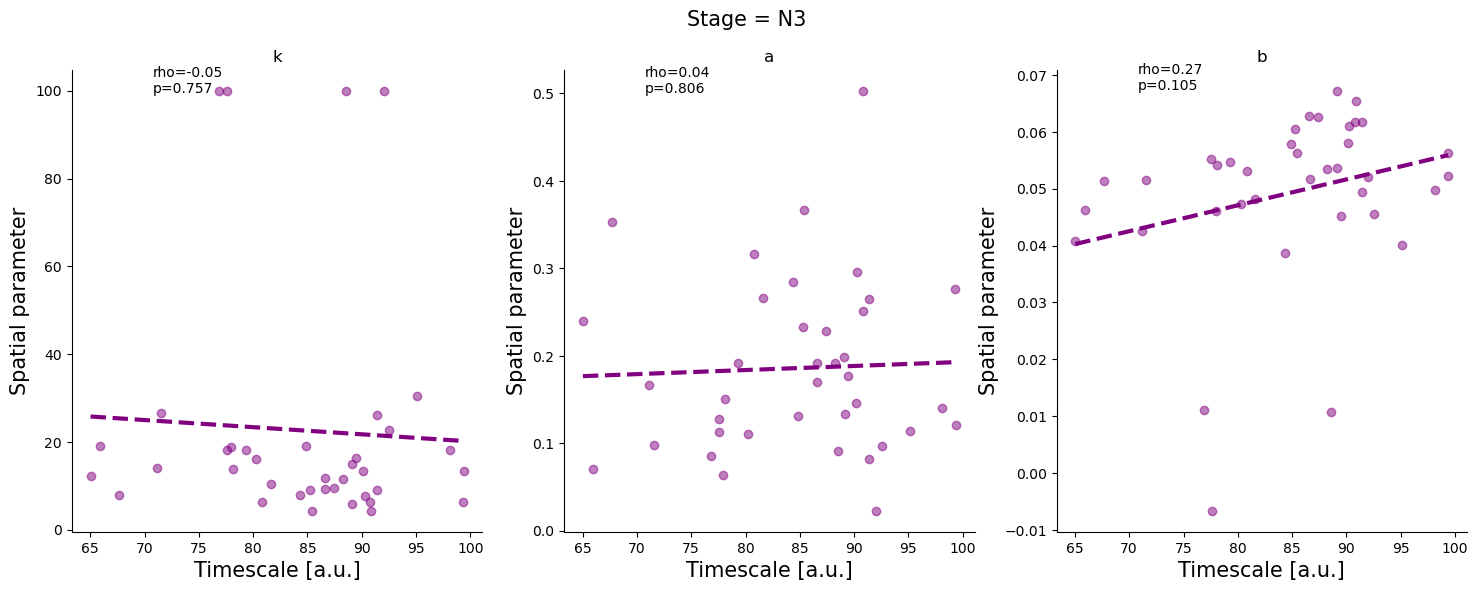

Stage: R, Param: k
Linregress results: r = -0.18803241196127846, p = 0.2582617018894288
Speraman results: r = -0.10931174089068825, p = 0.5135660171571469
Stage: R, Param: a
Linregress results: r = 0.4115785292558255, p = 0.010249553635578309
Speraman results: r = 0.12550607287449392, p = 0.4527711727496323
Stage: R, Param: b
Linregress results: r = -0.08657766197059852, p = 0.6052647440245437
Speraman results: r = -0.2239851187219608, p = 0.176419363349744


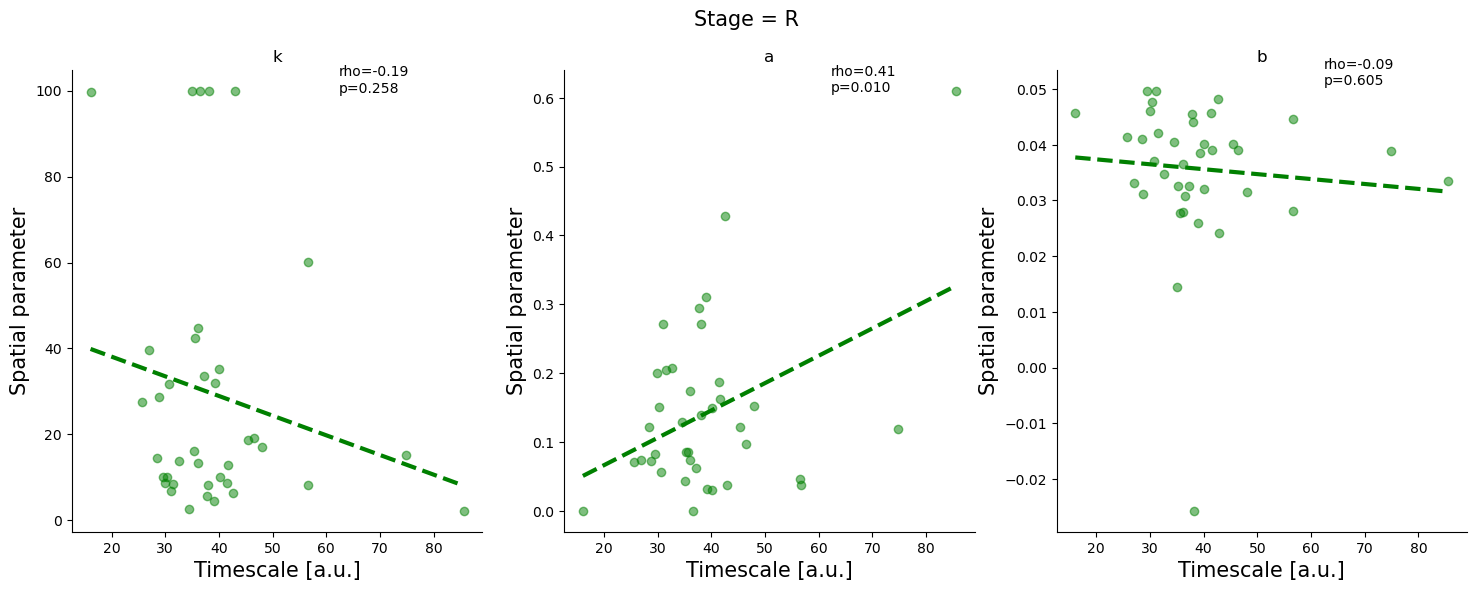

In [9]:
colors_stage = {
    "W": "r",
    "N3": "purple",
    "R": "g"
}

for stage in ["W", "N3", "R"]:

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18,6])
    fig.suptitle(f"Stage = {stage}", fontsize=15)

    # Plot one subplot per parameter
    for i, param in enumerate(["k", "a", "b"]):

        df_spa = df_sc_params_mni_stages_bins[stage][param].astype(float)
        print(f"Stage: {stage}, Param: {param}")
        axs[i] = plot_corr_tau_sc(axs[i], df_tau_stage_mni, df_spa, title=param, color=colors_stage[stage])
        
    plt.show()

With the MMP atlas division:

Stage: W, Param: k
Linregress results: r = 0.04311881547829581, p = 0.5858796376892159
Speraman results: r = -0.1366029688285334, p = 0.08303467852199604
Stage: W, Param: a
Linregress results: r = 0.027383968814074632, p = 0.7294126456400052
Speraman results: r = -0.02124446589637307, p = 0.7884419709606154
Stage: W, Param: b
Linregress results: r = -0.028386564907870733, p = 0.7199119348113519
Speraman results: r = 0.0980762418479143, p = 0.21437083715121505


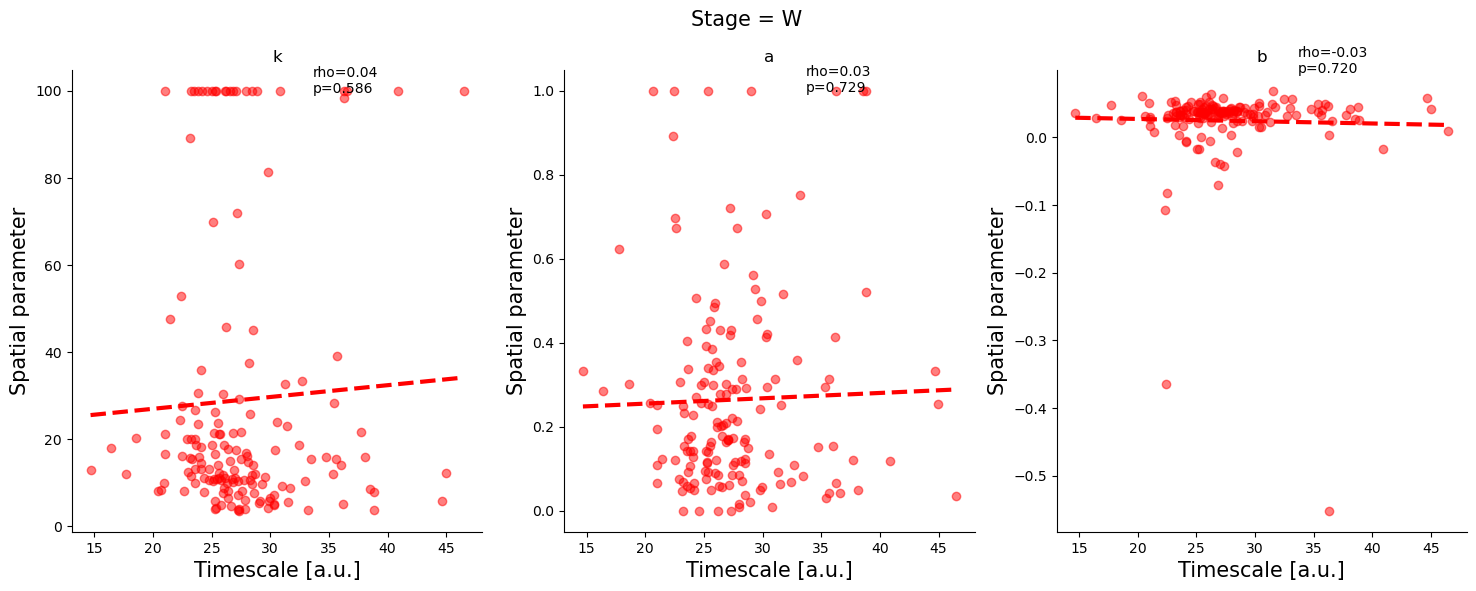

Stage: N3, Param: k
Linregress results: r = -0.08975160515089706, p = 0.26362876012067044
Speraman results: r = -0.12332557099997674, p = 0.12385389783587063
Stage: N3, Param: a
Linregress results: r = 0.03885155994861366, p = 0.629024039092378
Speraman results: r = -0.028902858888493577, p = 0.7193460777337375
Stage: N3, Param: b
Linregress results: r = 0.24736336186441893, p = 0.0017879124998203483
Speraman results: r = 0.2551274815646339, p = 0.0012609227195102735


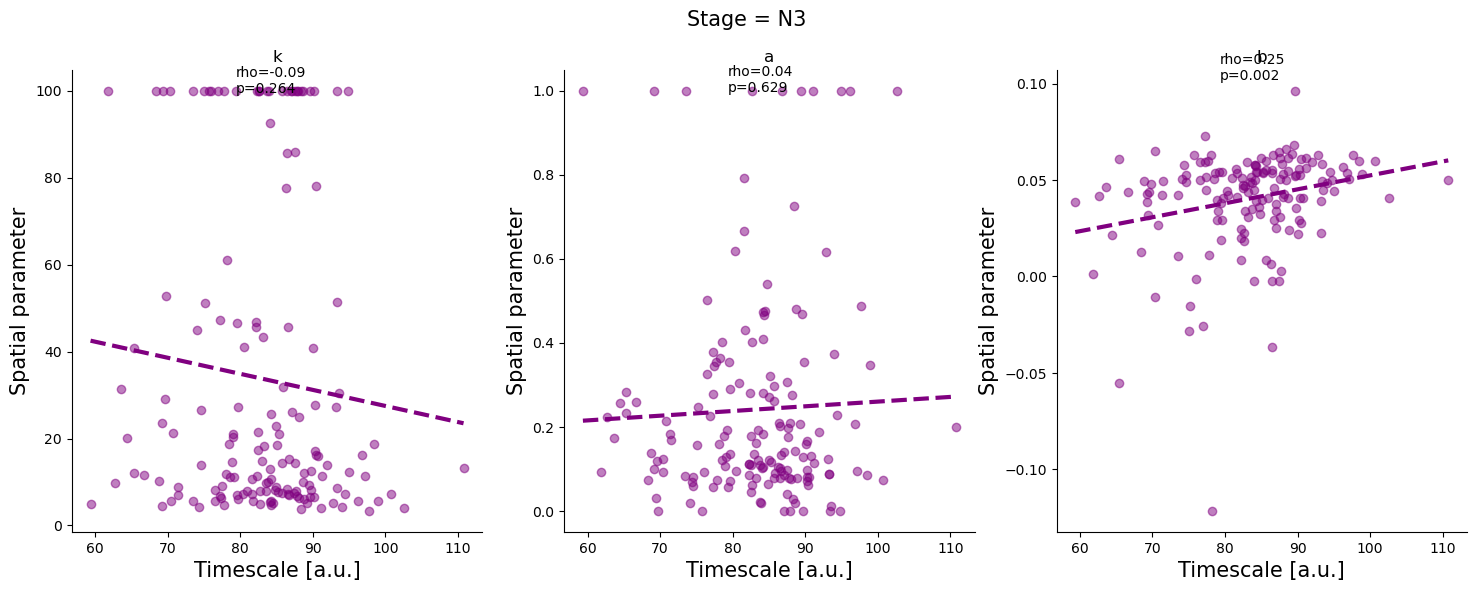

Stage: R, Param: k
Linregress results: r = -0.13290422539578237, p = 0.11228545827755093
Speraman results: r = -0.060708344753787086, p = 0.46979169834002776
Stage: R, Param: a
Linregress results: r = 0.18996441770698838, p = 0.02257731360522272
Speraman results: r = 0.11124619450560023, p = 0.18436186957813008
Stage: R, Param: b
Linregress results: r = -0.07135484586818917, p = 0.39539208289971284
Speraman results: r = -0.07484928864239208, p = 0.37259938778086954


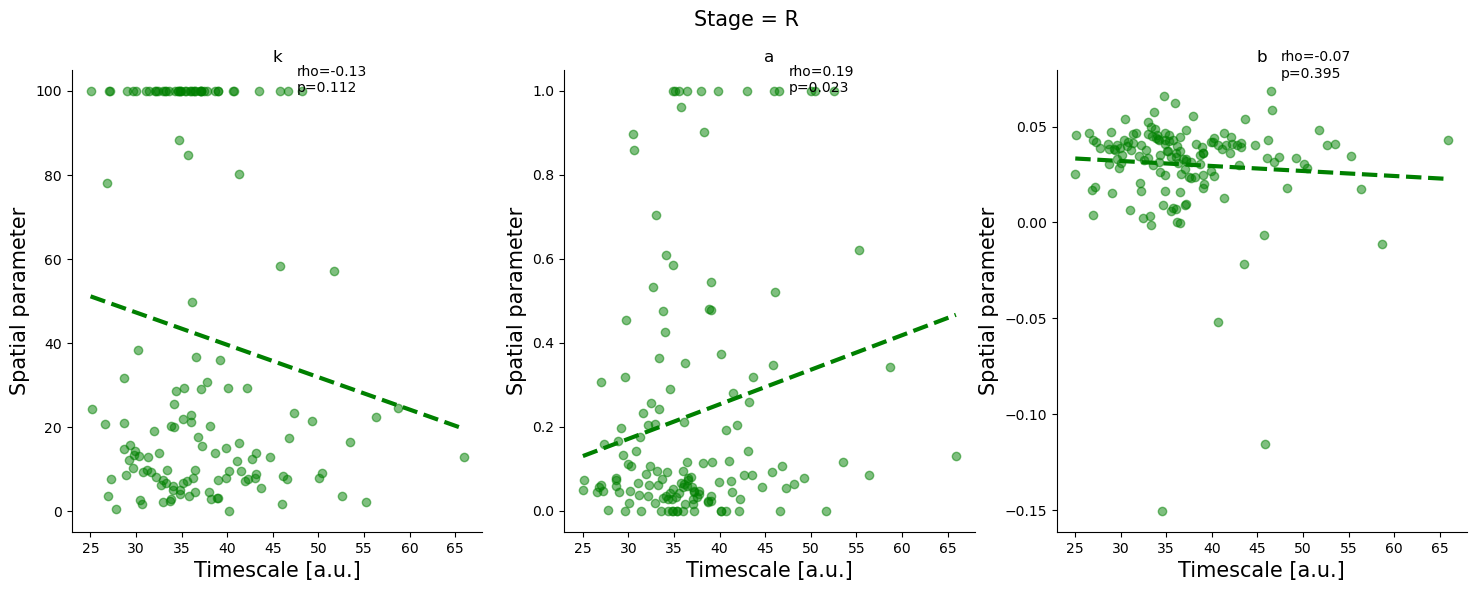

In [10]:
colors_stage = {
    "W": "r",
    "N3": "purple",
    "R": "g"
}

for stage in ["W", "N3", "R"]:

    # Get average tau per MNI region
    df_tau_stage_mmp = df_tau_parc[stage].copy()

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18,6])
    fig.suptitle(f"Stage = {stage}", fontsize=15)

    # Plot one subplot per parameter
    for i, param in enumerate(["k", "a", "b"]):

        df_spa = df_sc_params_mmp_stages_bins[stage][param].astype(float)
        df_spa.dropna(inplace=True)
        # Check same regions are present
        df_tau_stage_mmp = df_tau_stage_mmp[df_tau_stage_mmp.index.isin(df_spa.index)]
        print(f"Stage: {stage}, Param: {param}")
        axs[i] = plot_corr_tau_sc(axs[i], df_tau_stage_mmp, df_spa, title=param, color=colors_stage[stage])
        
    plt.show()

## Plot per channel (to check)

In [11]:
df_test_sc = df_sc_stages["W"].copy()
df_test_tau = df_tau[df_tau["stage"] == "W"].copy()

In [12]:
df_test_sc

,ch_1,ch_2,lobe_1,lobe_2,region_1,region_2,mmp_1,mmp_2,dist,corr_0,corr_max,lag_max,pat
0,GD001Lc_11,GD001Lc_12,Temporal,Temporal,Middle temporal gyrus,Middle temporal gyrus,STSvp,STSvp,4.472136,0.372675,0.372675,0,1
1,GD001Lc_11,GD001Lc_13,Temporal,Temporal,Middle temporal gyrus,Middle temporal gyrus,STSvp,TE1p,7.000000,0.231053,0.231053,0,1
2,GD001Lc_11,GD001Lc_14,Temporal,Temporal,Middle temporal gyrus,Middle temporal gyrus,STSvp,TE1p,12.041595,-0.301700,0.085737,7,1
3,GD001Lc_11,GD001Lo_1,Temporal,Frontal,Middle temporal gyrus,Medial frontal cortex,STSvp,10r,97.005155,-0.004742,0.032664,-58,1
4,GD001Lc_11,GD001Lo_2,Temporal,Frontal,Middle temporal gyrus,Medial frontal cortex,STSvp,10r,95.336247,-0.008198,0.022696,-80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19454,NG110RG64,NG110RI101,Frontal,Frontal,Frontal operculum,Supplementary motor cortex,45,24dv,74.747573,0.008876,0.027180,-55,110
19455,NG110RG64,NG110RI102,Frontal,Frontal,Frontal operculum,Supplementary motor cortex,45,24dv,73.585072,-0.000846,0.029166,-38,110
19456,NG110RG65,NG110RI101,Frontal,Frontal,Frontal operculum,Supplementary motor cortex,6r,24dv,72.839464,0.001983,0.031415,43,110
19457,NG110RG65,NG110RI102,Frontal,Frontal,Frontal operculum,Supplementary motor cortex,6r,24dv,72.715777,0.010784,0.031989,-26,110


In [13]:
df_test_tau

,pat,age,gender,chan,type,stage,region,mni_x,mni_y,mni_z,tau
0,1,34,['M'],GD001Lc_11,D,W,Middle temporal gyrus,-56.000000,-37.000000,-2.000000,15.477081
1,1,34,['M'],GD001Lc_12,D,W,Middle temporal gyrus,-60.000000,-37.000000,-4.000000,15.450481
2,1,34,['M'],GD001Lc_13,D,W,Middle temporal gyrus,-63.000000,-37.000000,-2.000000,15.336807
3,1,34,['M'],GD001Lc_14,D,W,Middle temporal gyrus,-68.000000,-38.000000,-2.000000,17.656101
4,1,34,['M'],GD001Lo_1,D,W,Medial frontal cortex,-1.000000,42.000000,-14.000000,22.687393
...,...,...,...,...,...,...,...,...,...,...,...
7053,110,27,['F'],NG110RG614,G,W,Postcentral gyrus (including medial segment),64.958333,-6.500000,13.666667,25.242406
7054,110,27,['F'],NG110RG64,G,W,Frontal operculum,48.464286,27.464286,-1.285714,24.641900
7055,110,27,['F'],NG110RG65,G,W,Frontal operculum,52.535714,15.035714,-0.214286,25.047029
7056,110,27,['F'],NG110RI101,G,W,Supplementary motor cortex,1.035714,-2.047619,48.380952,18.226162


In [14]:
df_test_tau_sc = pd.DataFrame(columns=["ch_1", "ch_2", "tau_1", "tau_2", "corr_max"])
df_test_tau_sc["ch_1"] = df_test_sc["ch_1"].copy()
df_test_tau_sc["ch_2"] = df_test_sc["ch_2"].copy()
df_test_tau_sc["tau_1"] = df_test_sc["ch_1"].map(df_test_tau.set_index("chan")["tau"])
df_test_tau_sc["tau_2"] = df_test_sc["ch_2"].map(df_test_tau.set_index("chan")["tau"])
df_test_tau_sc["dist"] = df_test_sc["dist"].copy()
df_test_tau_sc["corr_max"] = df_test_sc["corr_max"].copy()

LinregressResult(slope=0.09619914621198718, intercept=0.007426889464312331, rvalue=0.22536505427131323, pvalue=1.499386068227051e-222, stderr=0.0029814531689358738, intercept_stderr=0.0022244848196336727)


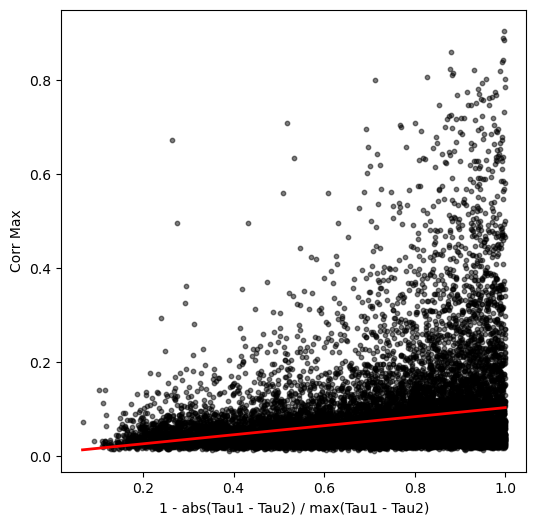

In [15]:
plt.figure(figsize=[6,6])
x_fit = 1 - np.abs(df_test_tau_sc["tau_1"] - df_test_tau_sc["tau_2"]) / np.maximum(df_test_tau_sc["tau_1"], df_test_tau_sc["tau_2"])
plt.scatter(x_fit, df_test_tau_sc["corr_max"], c="k", s=10, alpha=0.5)
res = linregress(x_fit, df_test_tau_sc["corr_max"])
print(res)
x = np.linspace(x_fit.min(), x_fit.max(), 100)
y = res.slope * x + res.intercept
plt.plot(x, y, "r", lw=2)
plt.xlabel("1 - abs(Tau1 - Tau2) / max(Tau1 - Tau2)", fontsize=10)
plt.ylabel("Corr Max", fontsize=10)
plt.show()

LinregressResult(slope=-26.421244661731322, intercept=61.46265384479604, rvalue=-0.2211360466751491, pvalue=3.807139207520737e-214, stderr=0.835350275044379, intercept_stderr=0.6232611752128452)


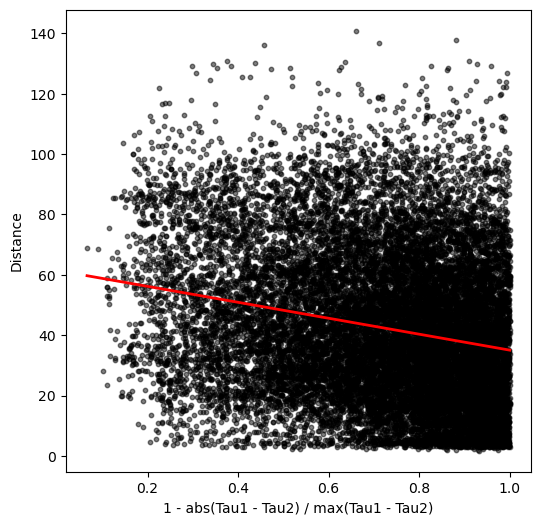

In [16]:
plt.figure(figsize=[6,6])
x_fit = 1 - np.abs(df_test_tau_sc["tau_1"] - df_test_tau_sc["tau_2"]) / np.maximum(df_test_tau_sc["tau_1"], df_test_tau_sc["tau_2"])
plt.scatter(x_fit, df_test_tau_sc["dist"], c="k", s=10, alpha=0.5)
res = linregress(x_fit, df_test_tau_sc["dist"])
print(res)
x = np.linspace(x_fit.min(), x_fit.max(), 100)
y = res.slope * x + res.intercept
plt.plot(x, y, "r", lw=2)
plt.xlabel("1 - abs(Tau1 - Tau2) / max(Tau1 - Tau2)", fontsize=10)
plt.ylabel("Distance", fontsize=10)
plt.show()

LinregressResult(slope=-0.0013619708351753459, intercept=0.13428924843549955, rvalue=-0.3812210696856648, pvalue=0.0, stderr=2.367839868661883e-05, intercept_stderr=0.0011657650517409748)


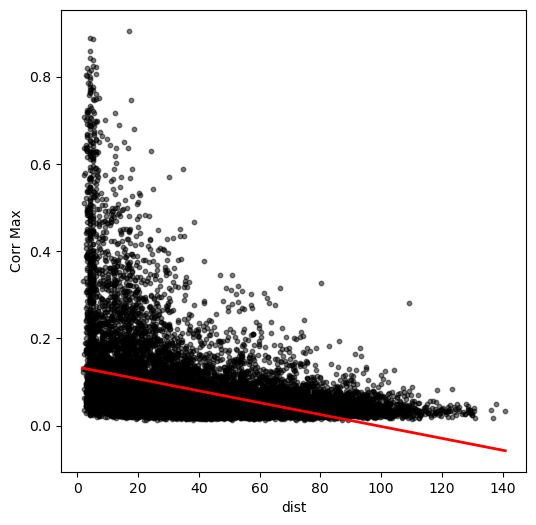

In [17]:
plt.figure(figsize=[6,6])
x_fit = df_test_tau_sc["dist"]
plt.scatter(x_fit, df_test_tau_sc["corr_max"], c="k", s=10, alpha=0.5)
res = linregress(x_fit, df_test_tau_sc["corr_max"])
print(res)
x = np.linspace(x_fit.min(), x_fit.max(), 100)
y = res.slope * x + res.intercept
plt.plot(x, y, "r", lw=2)
plt.xlabel("dist", fontsize=10)
plt.ylabel("Corr Max", fontsize=10)
plt.show()